# PPO算法实现教程：平衡杆环境

## 学习目标
- 理解PPO算法的核心概念
- 学会如何将代码从图像输入环境改为向量输入环境
- 掌握Actor-Critic网络结构的设计
- 理解GAE（广义优势估计）的计算
- 实现完整的PPO训练循环

## 第一步：导入必要的库和设置超参数

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from dataclasses import dataclass

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


In [2]:
# 定义超参数
@dataclass
class Args:
    env_id: str = "CartPole-v1"
    num_envs: int = 4
    num_steps: int = 128
    total_timesteps: int = 500000
    learning_rate: float = 2.5e-4
    anneal_lr: bool = True
    gamma: float = 0.99
    gae_lambda: float = 0.95
    clip_coef: float = 0.2
    clip_vloss: bool = True
    update_epochs: int = 4
    minibatch_size: int = 32
    norm_adv: bool = True
    ent_coef: float = 0.01
    vf_coef: float = 0.5
    max_grad_norm: float = 0.5
    target_kl: float = None


args = Args()
print("超参数设置完成")
print(f"环境: {args.env_id}")
print(f"并行环境数: {args.num_envs}")
print(f"总训练步数: {args.total_timesteps}")

超参数设置完成
环境: CartPole-v1
并行环境数: 4
总训练步数: 500000


## 第二步：创建环境

In [3]:
# 环境状态跟踪器
class EpisodeStatsWrapper(gym.Wrapper):
    """简单的回合统计包装器"""

    def __init__(self, env):
        super().__init__(env)
        self.reset_stats()

    def reset_stats(self):
        self.episode_return = 0
        self.episode_length = 0

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.episode_return += reward
        self.episode_length += 1

        # 回合结束时添加统计信息
        if done or truncated:
            info = info or {}
            info['episode_stats'] = {
                'return': self.episode_return,
                'length': self.episode_length
            }
            self.reset_stats()

        return obs, reward, done, truncated, info

    def reset(self, **kwargs):
        self.reset_stats()
        return self.env.reset(**kwargs)

def make_env(env_id, seed):
    """创建环境函数"""

    def thunk():
        env = gym.make(env_id)
        env = EpisodeStatsWrapper(env)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk

# 创建向量化环境
envs = gym.vector.SyncVectorEnv([make_env(args.env_id, i) for i in range(args.num_envs)])

print(f"环境: {args.env_id}")
print(f"观察空间: {envs.single_observation_space}")
print(f"动作空间: {envs.single_action_space}")

环境: CartPole-v1
观察空间: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
动作空间: Discrete(2)


## 第三步：定义网络结构

In [4]:
# 网络初始化
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

# PPO智能体网络
class PPOAgent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        obs_dim = np.array(envs.single_observation_space.shape).prod()
        n_actions = envs.single_action_space.n

        # 特征提取网络
        self.network = nn.Sequential(
            layer_init(nn.Linear(obs_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
        )

        # Actor和Critic头
        self.actor = layer_init(nn.Linear(64, n_actions), std=0.01)
        self.critic = layer_init(nn.Linear(64, 1), std=1)

    def get_value(self, x):
        return self.critic(self.network(x))

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)

        if action is None:
            action = probs.sample()

        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)

# 创建智能体和优化器
agent = PPOAgent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)

print("网络结构:")
print(agent)
print(f"\n网络参数数量: {sum(p.numel() for p in agent.parameters())}")

网络结构:
PPOAgent(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
  )
  (actor): Linear(in_features=64, out_features=2, bias=True)
  (critic): Linear(in_features=64, out_features=1, bias=True)
)

网络参数数量: 4675


## 第四步：初始化存储缓冲区

PPO需要存储一个rollout的所有数据用于后续的策略更新

In [5]:
# 计算训练参数
args.batch_size = args.num_envs * args.num_steps
num_updates = args.total_timesteps // args.batch_size

print(f"批量大小: {args.batch_size}")
print(f"更新次数: {num_updates}")

# 初始化存储
obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
values = torch.zeros((args.num_steps, args.num_envs)).to(device)

print("存储缓冲区初始化完成")
print(f"观察缓冲区形状: {obs.shape}")
print(f"动作缓冲区形状: {actions.shape}")

批量大小: 512
更新次数: 976
存储缓冲区初始化完成
观察缓冲区形状: torch.Size([128, 4, 4])
动作缓冲区形状: torch.Size([128, 4])


## 第五步：GAE（广义优势估计）实现

GAE是PPO中计算优势函数的关键算法，它平衡了偏差和方差

In [6]:
def compute_advantages(rewards, values, dones, next_value, gamma=0.99, gae_lambda=0.95):
    """
    计算GAE优势函数和回报
    
    Args:
        rewards: 奖励序列 [num_steps, num_envs]
        values: 状态价值序列 [num_steps, num_envs]
        dones: 结束标志序列 [num_steps, num_envs]
        next_value: 下一个状态的价值 [num_envs]
        gamma: 折扣因子
        gae_lambda: GAE参数
    
    Returns:
        advantages: 优势函数 [num_steps, num_envs]
        returns: 回报 [num_steps, num_envs]
    """
    num_steps = rewards.shape[0]
    advantages = torch.zeros_like(rewards)
    lastgaelam = 0

    for t in reversed(range(num_steps)):
        if t == num_steps - 1:
            nextnonterminal = 1.0 - dones[t]
            nextvalues = next_value
        else:
            nextnonterminal = 1.0 - dones[t + 1]
            nextvalues = values[t + 1]

        delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
        advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * lastgaelam

    returns = advantages + values
    return advantages, returns

# 创建智能体和优化器
agent = PPOAgent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)


## 第六步：开始训练

现在我们开始完整的PPO训练循环

In [7]:
# 环境状态跟踪
class EpisodeTracker:
    def __init__(self):
        self.episode_rewards = []
        self.episode_lengths = []
        self.current_returns = [0] * args.num_envs
        self.current_lengths = [0] * args.num_envs

    def step(self, rewards, dones, infos):
        """更新回合统计"""
        for i in range(args.num_envs):
            self.current_returns[i] += rewards[i].item()
            self.current_lengths[i] += 1

            # 检查回合是否结束
            if dones[i]:
                # 记录回合数据
                self.episode_rewards.append(self.current_returns[i])
                self.episode_lengths.append(self.current_lengths[i])

                # 重置计数器
                self.current_returns[i] = 0
                self.current_lengths[i] = 0

                return self.current_returns[i], self.current_lengths[i]
        return None, None

# 初始化训练
episode_tracker = EpisodeTracker()
writer = SummaryWriter("runs/PPO_CartPole_clean")

global_step = 0
next_obs = torch.Tensor(envs.reset()[0]).to(device)
next_done = torch.zeros(args.num_envs).to(device)

print("开始训练...")
print(f"初始观察形状: {next_obs.shape}")

开始训练...
初始观察形状: torch.Size([4, 4])


In [8]:
# 主训练循环
for update in range(1, num_updates + 1):
    # 学习率退火
    if args.anneal_lr:
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * args.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    update_episodes = 0
    update_rewards = []

    # 采样阶段
    for step in range(args.num_steps):
        global_step += args.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # 获取动作和价值
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()

        actions[step] = action
        logprobs[step] = logprob

        # 环境步进
        next_obs, reward, done, truncated, info = envs.step(action.cpu().numpy())
        done = np.logical_or(done, truncated)

        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs = torch.Tensor(next_obs).to(device)
        next_done = torch.Tensor(done).to(device)

        # 更新回合统计
        for i in range(args.num_envs):
            episode_tracker.current_returns[i] += reward[i]
            episode_tracker.current_lengths[i] += 1

            if done[i]:
                ep_reward = episode_tracker.current_returns[i]
                ep_length = episode_tracker.current_lengths[i]

                episode_tracker.episode_rewards.append(ep_reward)
                episode_tracker.episode_lengths.append(ep_length)
                update_episodes += 1
                update_rewards.append(ep_reward)

                # TensorBoard记录
                writer.add_scalar("charts/episodic_return", ep_reward, global_step)
                writer.add_scalar("charts/episodic_length", ep_length, global_step)

                # 重置计数器
                episode_tracker.current_returns[i] = 0
                episode_tracker.current_lengths[i] = 0

                if update_episodes <= 5:  # 只打印前几个回合避免输出过多
                    print(f"  回合完成 - 环境{i}: 奖励={ep_reward:.1f}, 长度={ep_length}")

    # 计算优势函数
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages, returns = compute_advantages(
            rewards, values, dones, next_value, args.gamma, args.gae_lambda
        )

    # 准备训练数据
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # 策略更新
    b_inds = np.arange(args.batch_size)
    clipfracs = []

    for epoch in range(args.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, args.batch_size, args.minibatch_size):
            end = start + args.minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(
                b_obs[mb_inds], b_actions.long()[mb_inds]
            )
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > args.clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if args.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # PPO策略损失
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - args.clip_coef, 1 + args.clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # 值函数损失
            newvalue = newvalue.view(-1)
            if args.clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds], -args.clip_coef, args.clip_coef
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - args.ent_coef * entropy_loss + v_loss * args.vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
            optimizer.step()

        if args.target_kl is not None and approx_kl > args.target_kl:
            break

    # 记录训练指标
    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)

    # 打印进度
    if update_episodes > 0:
        avg_update_reward = np.mean(update_rewards)
        print(f"更新 {update}: 完成 {update_episodes} 个回合, 平均奖励: {avg_update_reward:.2f}")

    if update % 10 == 0:
        total_episodes = len(episode_tracker.episode_rewards)
        if total_episodes > 0:
            recent_rewards = episode_tracker.episode_rewards[-50:]
            avg_reward = np.mean(recent_rewards)
            max_reward = max(episode_tracker.episode_rewards)

            print(f"\n=== 更新 {update}/{num_updates} ===")
            print(f"总回合数: {total_episodes}")
            print(f"最近50回合平均奖励: {avg_reward:.2f}")
            print(f"历史最高奖励: {max_reward:.2f}")
            print(f"策略损失: {pg_loss.item():.4f}")
            print(f"值函数损失: {v_loss.item():.4f}")

# 关闭环境和记录器
envs.close()
writer.close()

print(f"\n训练完成！")
print(f"总回合数: {len(episode_tracker.episode_rewards)}")

  回合完成 - 环境1: 奖励=16.0, 长度=16
  回合完成 - 环境0: 奖励=34.0, 长度=34
  回合完成 - 环境3: 奖励=41.0, 长度=41
  回合完成 - 环境1: 奖励=25.0, 长度=26
  回合完成 - 环境2: 奖励=43.0, 长度=43
更新 1: 完成 19 个回合, 平均奖励: 24.00
  回合完成 - 环境2: 奖励=39.0, 长度=40
  回合完成 - 环境3: 奖励=21.0, 长度=22
  回合完成 - 环境1: 奖励=13.0, 长度=14
  回合完成 - 环境3: 奖励=13.0, 长度=14
  回合完成 - 环境3: 奖励=19.0, 长度=20
更新 2: 完成 18 个回合, 平均奖励: 26.83
  回合完成 - 环境3: 奖励=15.0, 长度=16
  回合完成 - 环境1: 奖励=21.0, 长度=22
  回合完成 - 环境2: 奖励=19.0, 长度=20
  回合完成 - 环境0: 奖励=30.0, 长度=31
  回合完成 - 环境3: 奖励=45.0, 长度=46
更新 3: 完成 17 个回合, 平均奖励: 26.18
  回合完成 - 环境1: 奖励=57.0, 长度=58
  回合完成 - 环境2: 奖励=49.0, 长度=50
  回合完成 - 环境3: 奖励=29.0, 长度=30
  回合完成 - 环境1: 奖励=19.0, 长度=20
  回合完成 - 环境2: 奖励=31.0, 长度=32
更新 4: 完成 16 个回合, 平均奖励: 36.25
  回合完成 - 环境1: 奖励=19.0, 长度=20
  回合完成 - 环境3: 奖励=28.0, 长度=29
  回合完成 - 环境1: 奖励=43.0, 长度=44
  回合完成 - 环境3: 奖励=46.0, 长度=47
  回合完成 - 环境1: 奖励=28.0, 长度=29
更新 5: 完成 10 个回合, 平均奖励: 47.70
  回合完成 - 环境1: 奖励=19.0, 长度=20
  回合完成 - 环境0: 奖励=19.0, 长度=20
  回合完成 - 环境1: 奖励=33.0, 长度=34
  回合完成 - 环境2: 奖励=53.0, 长度=54
  回合完成 - 环境3: 

## 第七步：可视化训练结果

C:\Users\10240\AppData\Local\Temp\ipykernel_44416\200066957.py:38: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10240\AppData\Local\Temp\ipykernel_44416\200066957.py:38: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10240\AppData\Local\Temp\ipykernel_44416\200066957.py:38: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10240\AppData\Local\Temp\ipykernel_44416\200066957.py:38: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10240\AppData\Local\Temp\ipykernel_44416\200066957.py:38: UserWarning: Glyph 22870 (\N{CJK UNIFIED IDEOGRAPH-5956}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10240\AppData\Local\Temp\ipykernel_44416\200066957.py:38: UserWarning: Glyph 21169 (\N{CJK 

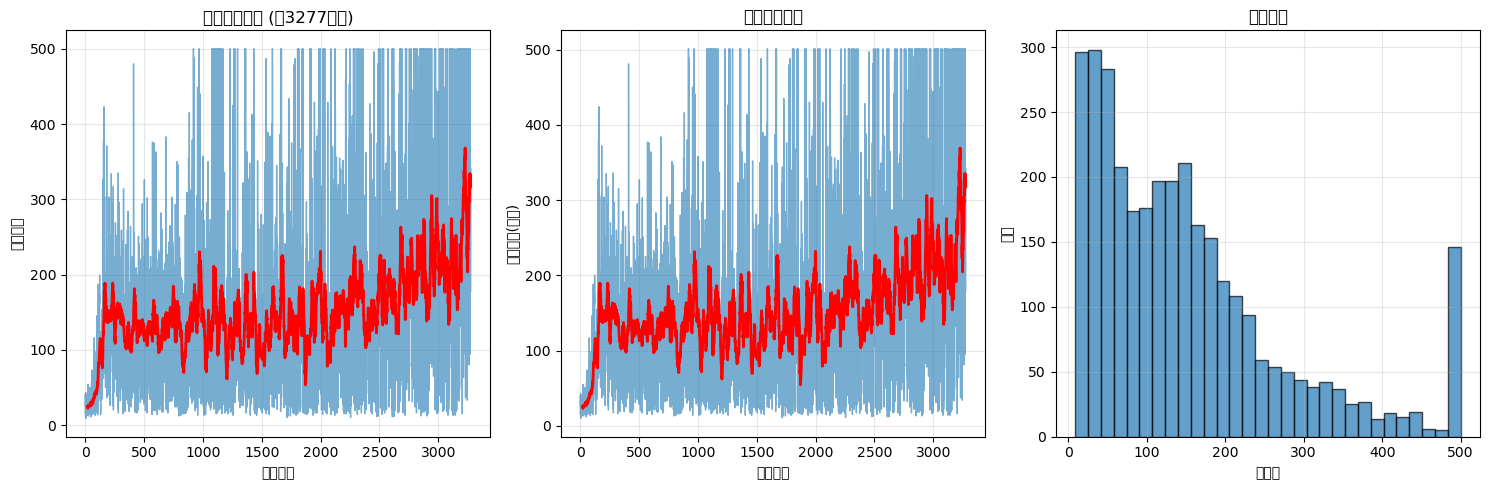


=== 训练统计报告 ===
总回合数: 3277
平均奖励: 151.38
标准差: 122.88
最高奖励: 500.00
最低奖励: 9.00
最后50回合平均: 273.62
👍 训练表现良好，还有改进空间


In [9]:
# 可视化结果
if episode_tracker.episode_rewards:
    plt.figure(figsize=(15, 5))

    # 回合奖励
    plt.subplot(1, 3, 1)
    plt.plot(episode_tracker.episode_rewards, alpha=0.6, linewidth=1)
    if len(episode_tracker.episode_rewards) > 20:
        window = min(20, len(episode_tracker.episode_rewards) // 5)
        moving_avg = np.convolve(episode_tracker.episode_rewards, np.ones(window) / window, mode='valid')
        plt.plot(range(window - 1, len(episode_tracker.episode_rewards)), moving_avg, 'r-', linewidth=2)
    plt.title(f'回合奖励趋势 (共{len(episode_tracker.episode_rewards)}回合)')
    plt.xlabel('回合序号')
    plt.ylabel('回合奖励')
    plt.grid(True, alpha=0.3)

    # 回合长度
    plt.subplot(1, 3, 2)
    plt.plot(episode_tracker.episode_lengths, alpha=0.6, linewidth=1)
    if len(episode_tracker.episode_lengths) > 20:
        window = min(20, len(episode_tracker.episode_lengths) // 5)
        moving_avg = np.convolve(episode_tracker.episode_lengths, np.ones(window) / window, mode='valid')
        plt.plot(range(window - 1, len(episode_tracker.episode_lengths)), moving_avg, 'r-', linewidth=2)
    plt.title('回合长度趋势')
    plt.xlabel('回合序号')
    plt.ylabel('回合长度(步数)')
    plt.grid(True, alpha=0.3)

    # 奖励分布
    plt.subplot(1, 3, 3)
    bins = min(30, len(episode_tracker.episode_rewards) // 3)
    plt.hist(episode_tracker.episode_rewards, bins=bins, alpha=0.7, edgecolor='black')
    plt.title('奖励分布')
    plt.xlabel('奖励值')
    plt.ylabel('频次')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 统计报告
    rewards = episode_tracker.episode_rewards
    print(f"\n=== 训练统计报告 ===")
    print(f"总回合数: {len(rewards)}")
    print(f"平均奖励: {np.mean(rewards):.2f}")
    print(f"标准差: {np.std(rewards):.2f}")
    print(f"最高奖励: {max(rewards):.2f}")
    print(f"最低奖励: {min(rewards):.2f}")

    # 性能分析
    last_50 = rewards[-50:] if len(rewards) >= 50 else rewards
    final_performance = np.mean(last_50)
    print(f"最后{len(last_50)}回合平均: {final_performance:.2f}")

    if final_performance > 400:
        print("🎉 训练表现优秀！智能体已经掌握平衡杆任务")
    elif final_performance > 200:
        print("👍 训练表现良好，还有改进空间")
    elif final_performance > 100:
        print("📈 训练有进展，需要继续优化")
    else:
        print("📚 需要调整超参数或增加训练时间")
else:
    print("❌ 没有收集到回合数据")

## 第八步：测试训练好的智能体

In [10]:
# 测试智能体性能
def evaluate_agent(agent, env_id, num_episodes=10):
    """评估训练好的智能体"""
    env = gym.make(env_id)
    test_rewards = []
    test_lengths = []

    print(f"\n开始评估智能体性能 ({num_episodes}回合)...")

    for episode in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False

        while not done and steps < 1000:  # 最大步数限制
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
            with torch.no_grad():
                action, _, _, _ = agent.get_action_and_value(obs_tensor)

            obs, reward, done, truncated, _ = env.step(action.cpu().item())
            total_reward += reward
            steps += 1
            done = done or truncated

        test_rewards.append(total_reward)
        test_lengths.append(steps)
        print(f"测试回合 {episode + 1:2d}: 奖励={total_reward:6.1f}, 步数={steps:3d}")

    env.close()

    avg_reward = np.mean(test_rewards)
    avg_length = np.mean(test_lengths)

    print(f"\n=== 测试结果 ===")
    print(f"平均奖励: {avg_reward:.2f}")
    print(f"平均长度: {avg_length:.2f}")
    print(f"成功率: {sum(1 for r in test_rewards if r >= 400) / len(test_rewards) * 100:.1f}%")

    if avg_reward >= 450:
        print("🏆 测试表现卓越！")
    elif avg_reward >= 350:
        print("🎯 测试表现优秀！")
    elif avg_reward >= 200:
        print("👍 测试表现良好！")
    else:
        print("📈 还有提升空间")

    return test_rewards, test_lengths


# 运行最终测试
test_rewards, test_lengths = evaluate_agent(agent, args.env_id, num_episodes=20)

print("\n训练和评估完成！")


开始评估智能体性能 (20回合)...
测试回合  1: 奖励= 156.0, 步数=156
测试回合  2: 奖励= 143.0, 步数=143
测试回合  3: 奖励=  17.0, 步数= 17
测试回合  4: 奖励= 282.0, 步数=282
测试回合  5: 奖励= 327.0, 步数=327
测试回合  6: 奖励=  33.0, 步数= 33
测试回合  7: 奖励= 500.0, 步数=500
测试回合  8: 奖励= 377.0, 步数=377
测试回合  9: 奖励=  55.0, 步数= 55
测试回合 10: 奖励=  66.0, 步数= 66
测试回合 11: 奖励= 280.0, 步数=280
测试回合 12: 奖励= 148.0, 步数=148
测试回合 13: 奖励= 174.0, 步数=174
测试回合 14: 奖励=  30.0, 步数= 30
测试回合 15: 奖励= 203.0, 步数=203
测试回合 16: 奖励= 329.0, 步数=329
测试回合 17: 奖励= 147.0, 步数=147
测试回合 18: 奖励= 351.0, 步数=351
测试回合 19: 奖励= 243.0, 步数=243
测试回合 20: 奖励= 158.0, 步数=158

=== 测试结果 ===
平均奖励: 200.95
平均长度: 200.95
成功率: 5.0%
👍 测试表现良好！

训练和评估完成！


### 1. PPO算法的核心组件
- **Actor-Critic架构**：Actor网络输出动作概率，Critic网络估计状态价值
- **PPO裁剪**：限制策略更新幅度，防止训练不稳定
- **GAE优势估计**：平衡偏差和方差的优势函数计算方法

### 2. 从图像到向量输入的适配
- 将卷积层改为全连接层
- 移除图像预处理步骤
- 调整网络大小以适应简单环境

### 3. 训练循环的关键步骤
- **采样阶段**：收集环境交互数据
- **优势计算**：使用GAE计算优势函数和回报
- **策略更新**：使用PPO损失函数更新网络参数

### 4. 超参数的重要性
- 学习率、裁剪系数、GAE参数等都会影响训练效果
- 可以通过调整这些参数来改善训练性能
